# Modelos lineales

Este notebook se enfoca en la implementación de modelos lineales (tanto de regresión como de clasificación) usando una vectorización estándar _Bag_of_Words_ (BoW).

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import StemmerTokenizer, df_to_list, process_df, procesar_adela
from utils.cargar import df_caso
import pandas as pd

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True,)

caso = 'adela'
df = df_caso(caso)
df = procesar_adela(df)
df = df[df['opt_left'] == 'Producir el alimento contra déficit vitamínico']
df = process_df(df,'comment','sel',verbose=False)
df = df.drop(columns=['user_id','team_id','gender','df','title','opt_left','opt_right','max_num','phase','time','curso'])

train_indices = pd.read_csv('../utils/splits/train_indices_{}'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

tokenized_corpus = [tokenizador(document) for document in df_train['comment']]
tokenized_test = [tokenizador(document) for document in df_test['comment']]

Partición train-test cargada


## Regresión con vectorizador Bag-of-Words

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from utils.preprocesamiento import make_BoW_preprocess, StemmerTokenizer

In [3]:
tokenizer = StemmerTokenizer(stem=False,rmv_punctuation=True,)
# preprocessing = make_BoW_preprocess(tokenizador,'comment',max_ngram=2,min_ngram=1,mindf=1)

bog_pipeline = Pipeline(
    [("Preprocessing", make_BoW_preprocess(tokenizador,'comment',max_ngram=2,min_ngram=1,mindf=1)),
    #  ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", GradientBoostingRegressor(n_estimators=100,max_depth=10))]
)

In [4]:
bog_pipeline.fit(df_train,df_train['sel'])

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  token_pattern=None,
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7fc6001c4a00>),
                                                  'comment')])),
                ('Clasificador', GradientBoostingRegressor(max_depth=10))])

In [5]:
import numpy as np

def reg_to_clf_output(reg_output):
    clf_output = np.round(reg_output).astype(int)
    clf_output = np.where(clf_output < 1, 1, clf_output)
    clf_output = np.where(clf_output > 6, 6, clf_output)
    return clf_output

In [6]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)
clf_y_pred = reg_to_clf_output(y_pred)

print("Resultados modelo Regresión lineal (BoW) como clasificador")
print(classification_report(df_test['sel'], clf_y_pred))

Resultados modelo Regresión lineal (BoW) como clasificador
              precision    recall  f1-score   support

           1       0.78      0.06      0.10       125
           2       0.44      0.41      0.43       292
           3       0.38      0.68      0.49       347
           4       0.32      0.35      0.33       205
           5       0.40      0.10      0.16       139
           6       1.00      0.02      0.04        46

    accuracy                           0.39      1154
   macro avg       0.55      0.27      0.26      1154
weighted avg       0.46      0.39      0.35      1154



In [7]:
df_bin = df.copy()

df_bin.loc[(df_bin['sel']==2) | (df_bin['sel']==3),'sel'] = 1
df_bin.loc[(df_bin['sel']==4) | (df_bin['sel']==5),'sel'] = 6

# df_train_bin = df_bin.iloc[train_indices]
df_test_bin = df_bin.iloc[test_indices]

clf_y_pred = np.where(clf_y_pred > 3.5, 6, clf_y_pred)
clf_y_pred = np.where(clf_y_pred < 3.5, 1, clf_y_pred)

print("Resultados modelo Regresión lineal como clasificación binaria")
print(classification_report(df_test_bin['sel'], clf_y_pred))

Resultados modelo Regresión lineal como clasificación binaria
              precision    recall  f1-score   support

           1       0.78      0.91      0.84       764
           6       0.75      0.50      0.60       390

    accuracy                           0.77      1154
   macro avg       0.77      0.71      0.72      1154
weighted avg       0.77      0.77      0.76      1154



In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the regressor using different metrics
mae = mean_absolute_error(df_test['sel'], y_pred)
mse = mean_squared_error(df_test['sel'], y_pred)
rmse = mean_squared_error(df_test['sel'], y_pred, squared=False)  # Calculate RMSE (set squared=False)
r2 = r2_score(df_test['sel'], y_pred)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error: 0.8184054402189633
Mean Squared Error: 1.1042945706157037
Root Mean Squared Error: 1.0508542099719178
R-squared (R2) Score: 0.35034603063861924


Búsqueda de grilla para mejores parámetros

In [9]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

grid = [{
        "Clasificador": [GradientBoostingRegressor()],
        "Clasificador__n_estimators":[100,150],
        "Clasificador__max_depth" : [3,6,12],
        "Preprocessing__bag-of-words__ngram_range":[(1,1), (1,2)],
        "Preprocessing__bag-of-words__min_df": [0,2,5],
    }]

hgs = HalvingGridSearchCV(bog_pipeline, grid, n_jobs=-1, scoring='r2', verbose=0)    

In [10]:
%%capture
hgs.fit(df_train,df_train['sel'])

In [11]:
hgs.best_params_ 

{'Clasificador': GradientBoostingRegressor(max_depth=6, n_estimators=150),
 'Clasificador__max_depth': 6,
 'Clasificador__n_estimators': 150,
 'Preprocessing__bag-of-words__min_df': 0,
 'Preprocessing__bag-of-words__ngram_range': (1, 2)}

Re-entrenamos el clasificador con los parámetros encontrados por temas de compatibilidad con la sección de tokens importantes.

In [12]:
n_estimators_hgs = hgs.best_params_['Clasificador'].n_estimators
max_depth_hgs = hgs.best_params_['Clasificador'].max_depth
mindf_hgs = hgs.best_params_['Preprocessing__bag-of-words__min_df']
min_ngram_hgs, max_ngram_hgs = hgs.best_params_['Preprocessing__bag-of-words__ngram_range']

bog_pipeline = Pipeline(
    [("Preprocessing", make_BoW_preprocess(tokenizador,'comment',max_ngram=max_ngram_hgs,min_ngram=min_ngram_hgs,mindf=mindf_hgs)),
    ("Clasificador", GradientBoostingRegressor(n_estimators=n_estimators_hgs,max_depth=max_depth_hgs))]
)

bog_pipeline.fit(df_train,df_train['sel'])

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(min_df=0,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  token_pattern=None,
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7fc6001c4a00>),
                                                  'comment')])),
                ('Clasificador',
                 GradientBoostingRegressor(max_depth=6, n_estimators=150))])

**Evaluación**: sometemos el regresor a una evaluación de clasificador para poder comparar los métodos (la inversa también será implementada: evaluar un clasificador como un regresor).

In [13]:
import numpy as np

def reg_to_clf_output(reg_output):
    clf_output = np.round(reg_output).astype(int)
    clf_output = np.where(clf_output < 1, 1, clf_output)
    clf_output = np.where(clf_output > 6, 6, clf_output)
    return clf_output

In [14]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)
clf_y_pred = reg_to_clf_output(y_pred)

print("Resultados modelo Regresión lineal (BoW) como clasificador")
print(classification_report(df_test['sel'], clf_y_pred))

Resultados modelo Regresión lineal (BoW) como clasificador
              precision    recall  f1-score   support

           1       0.67      0.03      0.06       125
           2       0.45      0.38      0.41       292
           3       0.38      0.70      0.49       347
           4       0.34      0.39      0.36       205
           5       0.44      0.09      0.14       139
           6       0.00      0.00      0.00        46

    accuracy                           0.39      1154
   macro avg       0.38      0.26      0.25      1154
weighted avg       0.41      0.39      0.34      1154



/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

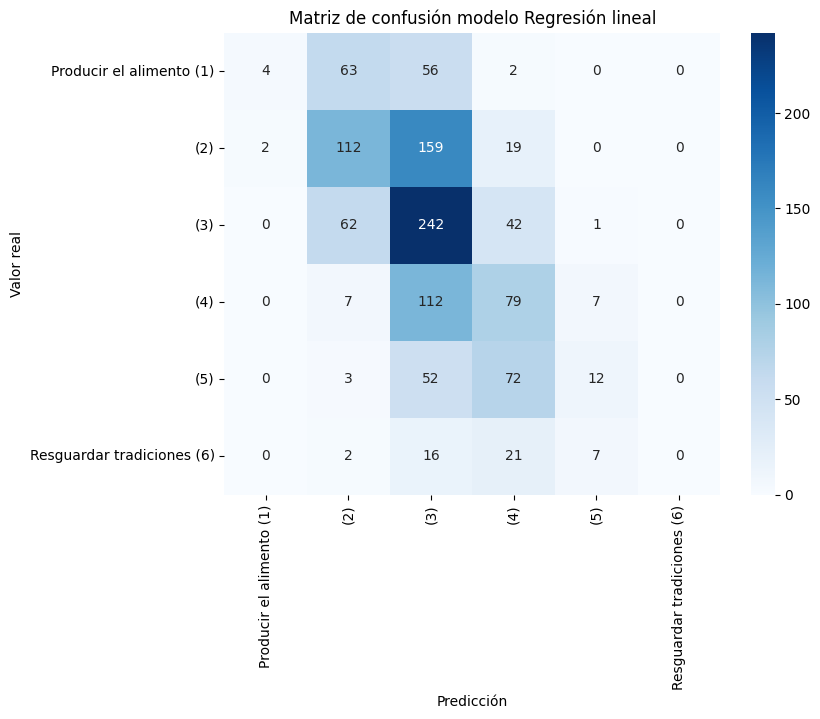

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df_test['sel'], clf_y_pred)

# Example class labels
class_labels = ['Producir el alimento (1)', '(2)', '(3)', '(4)', '(5)', 'Resguardar tradiciones (6)']

# Convert confusion matrix to NumPy array
cm_array = np.array(cm)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión modelo Regresión lineal')

# Show the plot
plt.show()

In [16]:
df_bin = df.copy()

df_bin.loc[(df_bin['sel']==2) | (df_bin['sel']==3),'sel'] = 1
df_bin.loc[(df_bin['sel']==4) | (df_bin['sel']==5),'sel'] = 6

# df_train_bin = df_bin.iloc[train_indices]
df_test_bin = df_bin.iloc[test_indices]

In [17]:
clf_y_pred = np.where(clf_y_pred > 3.5, 6, clf_y_pred)
clf_y_pred = np.where(clf_y_pred < 3.5, 1, clf_y_pred)

print("Resultados modelo Regresión lineal como clasificación binaria")
print(classification_report(df_test_bin['sel'], clf_y_pred))

Resultados modelo Regresión lineal como clasificación binaria
              precision    recall  f1-score   support

           1       0.78      0.92      0.85       764
           6       0.76      0.51      0.61       390

    accuracy                           0.78      1154
   macro avg       0.77      0.71      0.73      1154
weighted avg       0.77      0.78      0.76      1154



Resultados similares a Naive-Bayes

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the regressor using different metrics
mae = mean_absolute_error(df_test['sel'], y_pred)
mse = mean_squared_error(df_test['sel'], y_pred)
rmse = mean_squared_error(df_test['sel'], y_pred, squared=False)  # Calculate RMSE (set squared=False)
r2 = r2_score(df_test['sel'], y_pred)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error: 0.8306862261345769
Mean Squared Error: 1.1211891038847301
Root Mean Squared Error: 1.0588621741684467
R-squared (R2) Score: 0.34040701536970286


### Interpretabilidad: buscando tokens significativos